In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
from wavespectra import read_ndbc
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### Datos NDBC

In [3]:
# Espectros direccionales
# Carga de los datos en formato no direccional
ds = read_ndbc('../data/ocean/dir2023.nc', weight_coeff = True).isel(lat=0, lon=0)
freq = ds['freq'].to_numpy()
dir = ds['dir'].to_numpy()
data = ds['efth'].to_numpy()
ds_n = read_ndbc('../data/ocean/dir2023.nc', directional=False).isel(lat=0, lon=0)
data_no_direct = ds_n['efth'].to_numpy()

In [4]:
print(data.shape)
print(freq)
num_samples, num_obs_per_sample, num_outputs = data.shape

(8744, 47, 36)
[0.02   0.0325 0.0375 0.0425 0.0475 0.0525 0.0575 0.0625 0.0675 0.0725
 0.0775 0.0825 0.0875 0.0925 0.1    0.11   0.12   0.13   0.14   0.15
 0.16   0.17   0.18   0.19   0.2    0.21   0.22   0.23   0.24   0.25
 0.26   0.27   0.28   0.29   0.3    0.31   0.32   0.33   0.34   0.35
 0.365  0.385  0.405  0.425  0.445  0.465  0.485 ]


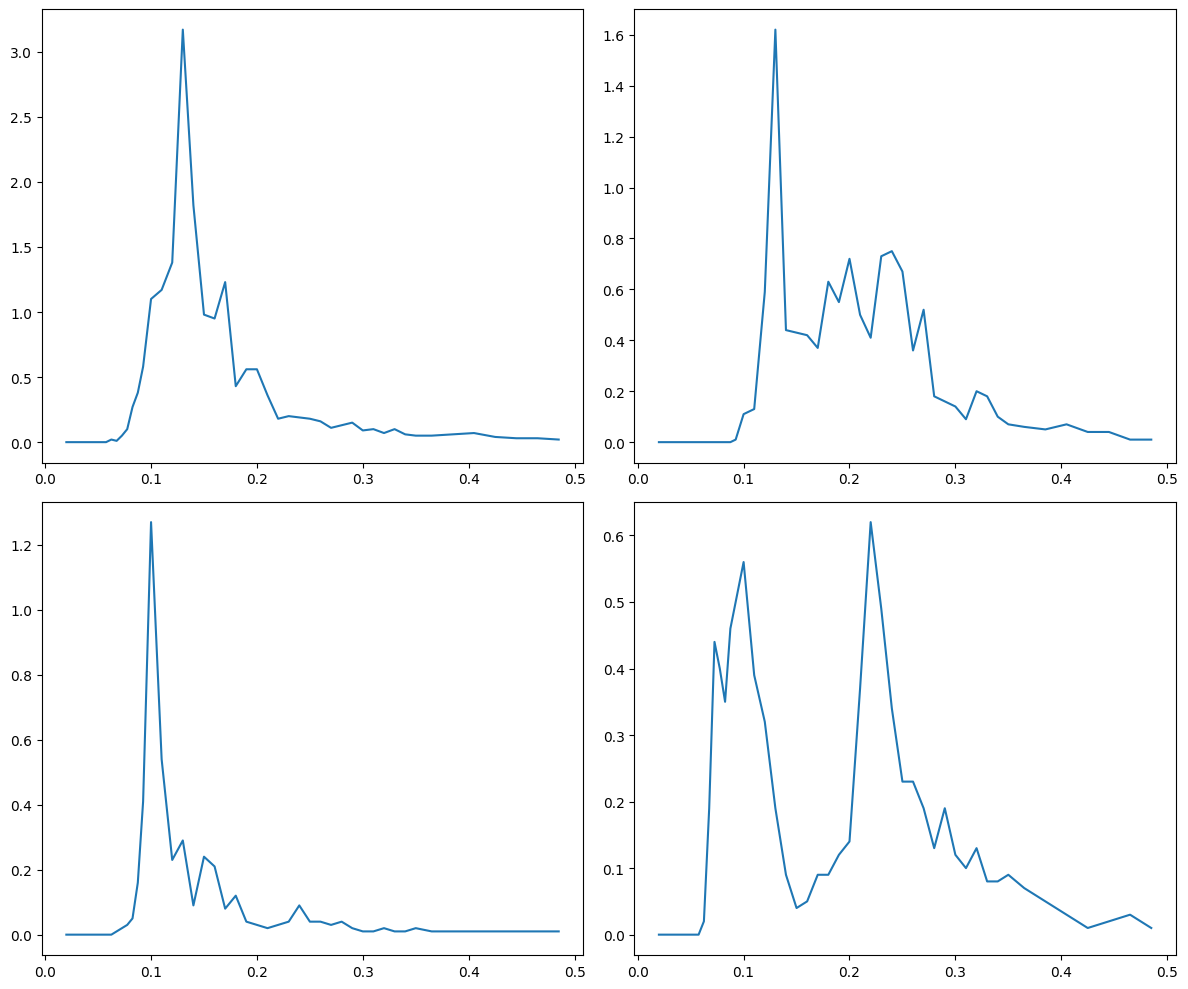

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfica 1
axs[0, 0].plot(freq, data_no_direct[0, :])

# Gráfica 2
axs[0, 1].plot(freq, data_no_direct[127, :])

# Gráfica 3
axs[1, 0].plot(freq, data_no_direct[35, :])

# Gráfica 4
axs[1, 1].plot(freq, data_no_direct[5923, :])

# Ajustar el layout para evitar superposición
plt.tight_layout()
plt.show()

Shape of hs: (8744, 1)
How much spectra falls in the range 0.5-3.0 Hs: 8744


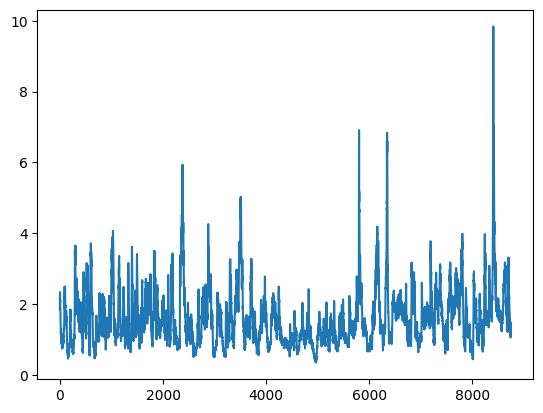

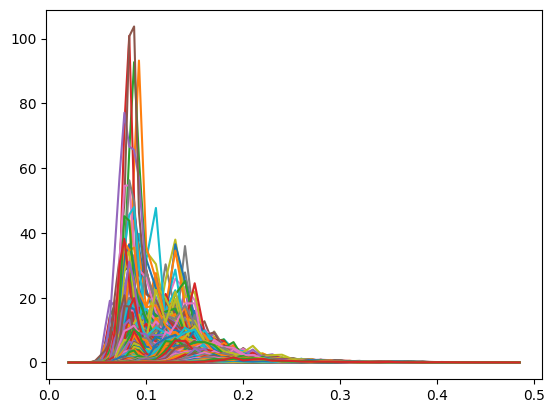

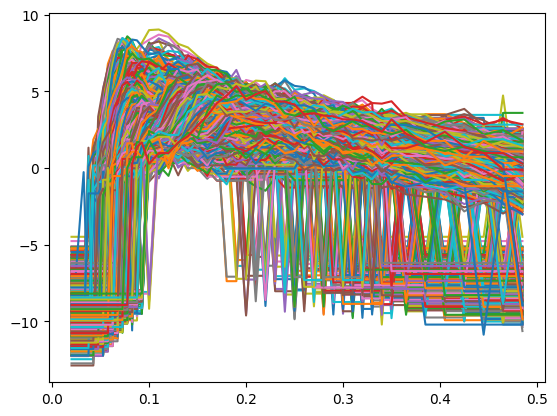

In [6]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data_no_direct @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.2) & (hs < 20.0))[0]
#chosen_indexes = np.arange(0, num_samples)
print("How much spectra falls in the range 0.5-3.0 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data_no_direct[chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_no_direct + 1e-6) - np.mean(np.log(data_no_direct+ 1e-6), axis=1)[:,np.newaxis]
plt.plot(freq, lognorm_data[chosen_indexes].T)
plt.show()


In [7]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(8744, 47, 36)


In [8]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 1.0
std_dif = std_dif * 1.0
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 6.008911781213203e-06
Gamma estimated: 6.008911781213203e-06
Final sigma: 6.008911781213203e-06
Final gamma: 6.008911781213203e-06
Final sigma bound: (6.008911781213202e-13, 6.008911781213203e-07)
Final gamma bound: (6.008911781213203e-15, 6.008911781213203e-07)


(35, 1)


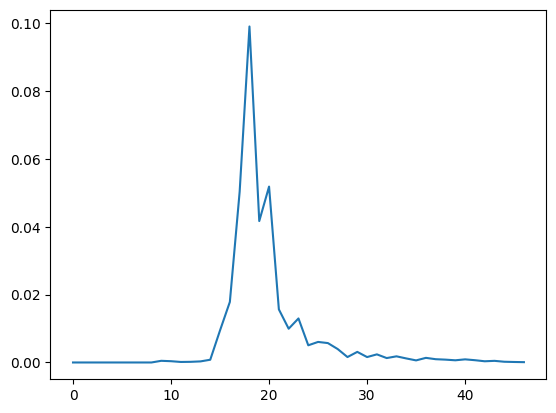

In [9]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 1.0
ini_lengthscale = 1e-2
bound_lengthscale = (1e-7, 5e-1)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
n_freq = 35
x_basis = np.atleast_2d(freq[0:n_freq]).T
x_train = np.atleast_2d(freq[0:n_freq]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = x_basis
plt.plot(data[291,:,22])
plt.show()

In [10]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=36,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=20, free_deg_MNIV=5, share_gp=True, use_snr=False, reduce_outputs=True, reduce_outputs_ratio=0.5)

#logdata = np.log(data + 1e-6)
selected_samples = np.arange(0, data.shape[0], 4)
num_samples = selected_samples.shape[0]
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data[selected_samples,:n_freq,:])

------ HDP Hyperparameters ------
gamma: 0.8
transAlpha: 0.8
startAlpha: 0.8
kappa: 0.0
---------------------------------
Performed reduction of outputs based on variance.
Ratio of reduction: 0.5 Final outputs: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Group responsability estimated: [2186]
---Kernel estimated---
0.00288**2 * RBF(length_scale=0.0368) + WhiteKernel(noise_level=5.99e-07)

-----------Lead 1-----------

-----------Lead 2-----------

-----------Lead 3-----------

-----------Lead 4-----------

-----------Lead 5-----------

-----------Lead 6-----------

-----------Lead 7-----------

-----------Lead 8-----------

-----------Lead 9-----------

-----------Lead 10-----------

-----------Lead 11-----------

-----------Lead 12-----------

-----------Lead 13-----------

-----------Lead 14-----------

-----------Lead 15-----------

-----------Lead 16-----------

-----------Lead 17-----------

-----------Lead 18-----------
Step 1/20- Trying to divide: 0 with beat 2101
Su

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.templates.default = 'plotly'

def plot_spectral_grid(ds, time_indices):

    angle_offsets = {
    0: 0,   # Desplazamiento para 0°
    45: 0.02,  # Desplazamiento para 45°
    90: 0.15,  # Desplazamiento para 90°
    135: 0.25,  # Desplazamiento para 135°
    180: 0.25, # Desplazamiento para 180°
    225: 0.25, # Desplazamiento para 225°
    270: 0.15, # Desplazamiento para 270°
    315: 0   # Desplazamiento para 315°
    }

    num_plots = len(time_indices)
    cols = min(2, num_plots)
    rows = (num_plots // cols) + (num_plots % cols > 0)

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f'Time {t}' for t in time_indices],
                        specs=[[{'type': 'surface'}] * cols for _ in range(rows)])
    max_z_value = np.max(ds.efth.values[time_indices])
    for idx, time in enumerate(time_indices):
        row, col = divmod(idx, cols)
        ds2 = ds.isel(time=time)
        ds2 = ds2.sel(freq=(ds2.freq >= 0.04) & (ds2.freq <= 0.4))
        ds2 = ds2.sel(freq=(ds2.freq >= 0.04) & (ds2.freq <= 0.4))

        frequencies = ds2.freq.values
        directions = np.radians(ds2.dir.values)
        energy_spectral = ds2.efth.values

        Theta, Freq = np.meshgrid(frequencies, directions)
        X = Theta * np.cos(Freq)
        Y = Theta * np.sin(Freq)
        Z = energy_spectral.T

        surface = go.Surface(x=X, y=-Y, z=Z, colorscale='Spectral_r', opacity=1, showlegend=False, showscale=False)
        fig.add_trace(surface, row=row+1, col=col+1)

        # Círculos internos y bordes
        max_frequency = np.max(frequencies)

        # Definir los radios como una fracción del valor máximo
        circle_radii = [0.75 * max_frequency, 0.5 * max_frequency, 0.25 * max_frequency]

        # Graficar los círculos con los nuevos radios ajustados
        for freq in circle_radii:
            circle_x = freq * np.cos(np.linspace(0, 2 * np.pi, 100))
            circle_y = freq * np.sin(np.linspace(0, 2 * np.pi, 100))
            fig.add_trace(go.Scatter3d(
                x=circle_x,
                y=circle_y,
                z=np.zeros_like(circle_x),
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)
        # Bordes de la circunferencia
        border_x = 0.4 * np.cos(np.linspace(0, 2 * np.pi, 100))
        border_y = 0.4 * np.sin(np.linspace(0, 2 * np.pi, 100))
        fig.add_trace(go.Scatter3d(
            x=border_x,
            y=border_y,
            z=np.zeros_like(border_x),
            mode='lines',
            line=dict(color='black', width=1)
        ), row=row+1, col=col+1)

        # Graficar radios y etiquetas de dirección (cada 30 grados)
        for angle in range(0, 360, 45):
            rad = np.radians(-angle)
            x = 0.4 * np.cos(rad)
            y = 0.4 * np.sin(rad)

            fig.add_trace(go.Scatter3d(
                x=[0, x],
                y=[0, y],
                z=[0, 0],
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)
            fig.add_trace(go.Scatter3d(
                x=[x],
                y=[y],
                z=[0],
                mode='text',
                text=[f"{angle}°"],
                showlegend=False,
                textposition='bottom center'
            ), row=row+1, col=col+1)

    fig.update_layout(
        height=800 * rows,  # Aumentar tamaño de las figuras
        width=600 * cols,  # Aumentar tamaño de las figuras
        title_text='Spectral Energy Distribution',
        showlegend=False)

    for i in range(1, num_plots + 1):
        fig.update_scenes(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            bgcolor='rgba(0,0,0,0)',  # Fondo transparente
            row=(i - 1) // cols + 1,
            col=(i - 1) % cols + 1
        )

    fig.show()
    #fig.show(renderer="svg")
    #fig.write_html('../data/ocean/plot_3d.html', auto_open=True)

In [21]:
indexes = []
for gp in sw_gp.gpmodels[0]:
    indexes.append(gp.indexes[0])
print(indexes)
plot_spectral_grid(ds, indexes)

[3, 79, 0, 25, 251, 1439, 1455, 594, 147, 1451, 2103, 1586, 2100, 2101, 1450, 2102]


tensor([0.0539, 0.0544, 0.0549, 0.0554, 0.0559, 0.0563, 0.0566, 0.0568, 0.0569,
        0.0568, 0.0566, 0.0564, 0.0560, 0.0555, 0.0551, 0.0546, 0.0541, 0.0536])
Model 1 : MainModel: N : [N-1238]
Model 2 : MainModel: N : [N-478]
Model 3 : MainModel: N : [N-315]
Model 4 : MainModel: N : [N-67]
Model 5 : MainModel: N : [N-31]
Model 6 : MainModel: N : [N-23]
Model 7 : MainModel: N : [N-12]
Model 8 : MainModel: N : [N-9]
Model 9 : MainModel: N : [N-4]
Model 10 : MainModel: N : [N-3]
Model 11 : MainModel: N : [N-1]
Model 12 : MainModel: N : [N-1]
Model 13 : MainModel: N : [N-1]
Model 14 : MainModel: N : [N-1]
Model 15 : MainModel: N : [N-1]
Model 16 : MainModel: N : [N-1]
Classification error: 0 / 2186 -- 0.00000


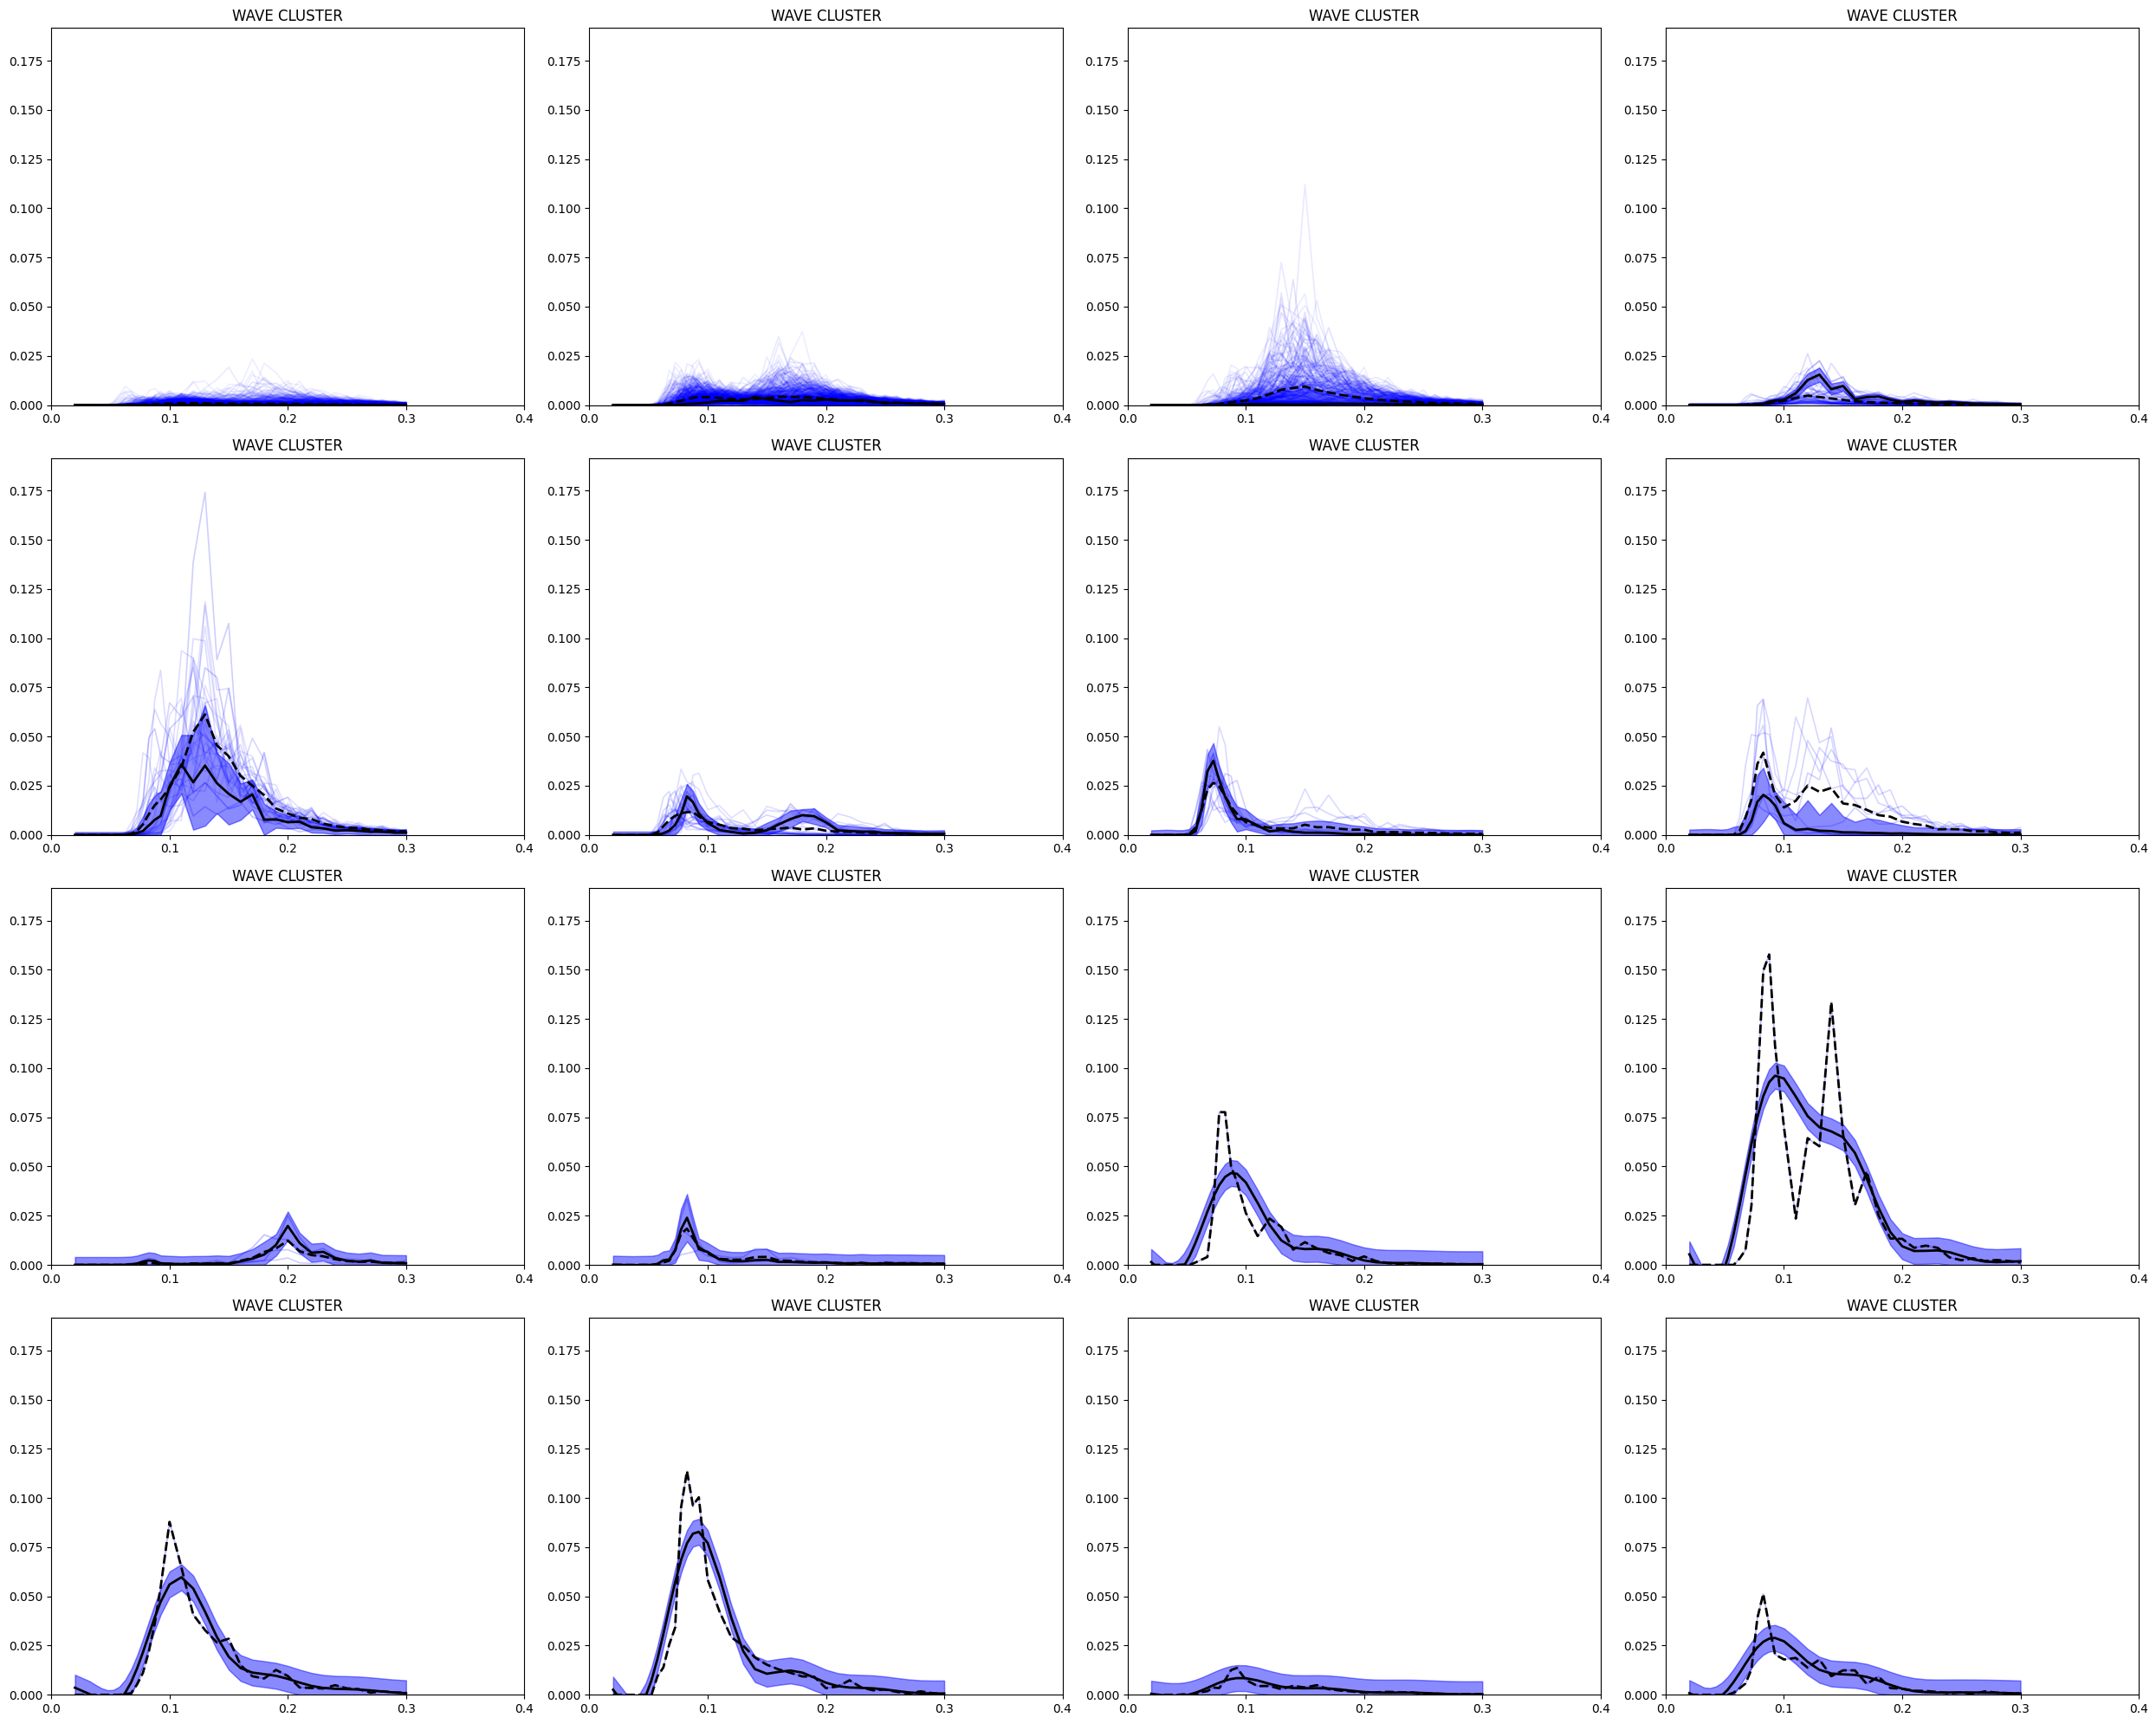

In [22]:
from hdpgpc.util_plots import plot_models_plotly
print(sw_gp.snr_norm[0])
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_ndbc.png")

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


GIF saved as 'function_evolution.gif'


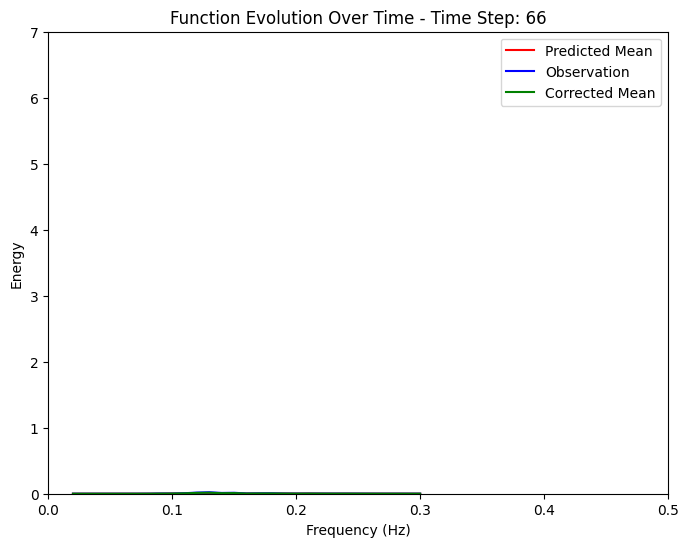

In [14]:
from hdpgpc.util_plots import FunctionEvolutionVisualizer

gp = sw_gp.gpmodels[0][3]
initial_step = 53
num_steps = 15 * 4  # Number of time steps to simulate

# Create visualizer instance
visualizer = FunctionEvolutionVisualizer(gp, initial_step, num_steps)

# Generate animation and save as GIF
visualizer.create_animation(output_filename="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/function_evolution.gif")
print("GIF saved as 'function_evolution.gif'")

import pickle as plk
with open("sw_gp_ndbc.plk", 'wb') as inp:
    plk.dump(sw_gp, inp)